# Predicting Newsletter Subscription from Player Age and Playtime in Minecraft

# Introduction:
A research group in the Department of Computer Science at the University of British Columbia (UBC), led by Professor Frank Wood, is conducting an ongoing study on human behavior in virtual environments. As part of this project, the team has deployed a Minecraft server that logs detailed data on how players interact with the game world. Minecraft, being a highly flexible sandbox game, offers a rich environment for studying decision-making, engagement, and behavioral trends in open-ended digital spaces.

The goal of this project is to investigate whether a player’s age and total hours played can predict their newsletter subscription status. Newsletter subscriptions may serve as a proxy for player interest, long-term engagement, or willingness to participate in community-driven content. Identifying behavioral or demographic predictors of subscription could help researchers and developers improve player retention strategies and tailor outreach to specific player profiles.

The central research question is:
### Can player age and hours played predict whether a player is subscribed to the newsletter in the `players.csv` dataset?

To address this question, we analyzed data from the `players.csv` dataset, which contains information on individual players, including gameplay engagement and basic demographics. The dataset includes the following variables:

- experience (character): Player’s experience level, categorized as Beginner, Amateur, Regular, Veteran, or Pro.

- subscribe (logical): `TRUE` if the player is subscribed to the game newsletter; `FALSE` otherwise.

- hashedEmail (character): An anonymized, unique identifier for each player.

- played_hours (double): The total number of hours the player has spent in-game.

- name (character): Player’s name.

- gender (character): Player’s gender.

- Age (double): Player’s age.

| Dataset   | Number of Rows | Number of Variables | 
|---------------|---------|------------|
 |`players.csv`| 196  |   7      |    
<p style="text-align: center;"><strong>Table 1:</strong> Dataset Dimensions — Number of Rows and Variables in <code>players.csv</code></p>


### Issues: 
- Missing Values: Some values are missing in the "Age" variable.
- Only players who joined the Minecraft server are included in the dataset. There may be missing players who signed in but never played long enough to produce data.
- Several cases where played_hours is recorded as 0.0, which could indicate that the player did not engage in the game or that their activity was not properly logged.






# Methods & Results

### Data Loading
We began by loading the necessary R packages for data analysis and visualization. Specifically, we used `tidyverse` and `tidymodels` for data manipulation and modeling, `ggplot2` and `RColorBrewer` for visualizations, and `repr` to control plot display dimensions in the Jupyter notebook environment. We then read the `players.csv` dataset, which contains player-level data, including age, total hours played, and newsletter subscription status. These variables were the primary focus of our predictive analysis.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(ggplot2)

options(repr.plot.width = 12, repr.plot.height = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
players <- read.csv("https://raw.githubusercontent.com/EL2406/DSCI100/refs/heads/master/players.csv")
head(players)
set.seed(25)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Clean and select variables ###
To address our research question, we focused on three relevant variables: Age, played_hours, and subscribe. We selected only these columns from the dataset and removed any rows containing missing values to ensure the integrity of the analysis and avoid complications during model fitting.

The `subscribe` variable was originally stored as a logical (`TRUE`/`FALSE`). For compatibility with classification modeling in the `tidymodels` framework, we converted this variable to a factor using the `as.factor()` function. We then checked the levels of the factor to determine the appropriate `event_level`, which specifies which class should be treated as the “positive” outcome in our evaluation metrics. This step ensures that model performance metrics, such as precision and recall, are calculated relative to the correct target class (i.e., subscribed players).

In [10]:
players_clean <- players |>
  select(Age, played_hours, subscribe) |>
  drop_na() |>
  mutate(subscribe = as.factor(subscribe))
levels(players_clean$subscribe)
head(players_clean)

[1] "FALSE" "TRUE"

,Age,played_hours,subscribe
,<int>,<dbl>,<fct>
1,9,30.3,TRUE
2,17,3.8,TRUE
3,17,0.0,FALSE
4,21,0.7,TRUE
5,21,0.1,TRUE
6,17,0.0,TRUE


### Summary of the Dataset
We performed a statistical summary of the cleaned dataset to better understand the distribution of the variables used in the analysis. Summary statistics for Age and played_hours included the minimum, maximum, mean, median, and standard deviation, providing insight into the central tendency and variability of the data.

In [9]:
mean_data <- players_clean|>
  select(played_hours, Age) |>
  map_df(mean, na.rm = TRUE)

max_data <- players_clean|>
  select(played_hours, Age) |>
  map_df(max, na.rm = TRUE)

min_data <- players_clean|>
  select(played_hours, Age) |>
  map_df(min, na.rm = TRUE)


| Variable   | Mean Value | Maximum Value | Minimum Value |
|---------------|---------|------------|--------------|
 |Played Hours| 5.9   |   223.1       |      0        |
 |Age         |20.5    |     50        |      8        |
<p style="text-align: center;"><strong>Table 2:</strong> Summary Statistics for Played Hours and Age</p>



### Exploratory Data Visualization
To explore potential relationships between the predictor variables and subscription status, we created two visualizations. The first plot examined the distribution of age by subscription status, allowing us to assess whether age differs noticeably between subscribed and non-subscribed players. The second plot explored the relationship between total hours played and subscription status. These visualizations helped us identify potential trends or separation between the two classes, which could indicate predictive value in these features.

### Data Splitting
To evaluate how well our model performs on new data, we split the dataset into a training set and a testing set. We used 75 percent of the data for training and 25 percent for testing, ensuring that the model would be trained on the majority of the data while reserving a separate portion for unbiased evaluation. 

In [11]:
player_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

### Create Cross-Validation Folds
Before training the model, we applied 5-fold cross-validation to the training data. The purpose of this step was to obtain a more reliable estimate of model performance and to reduce the risk of overfitting.

In [12]:
player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

### Set up a data preprocessing recipe
In this step, we created a preprocessing pipeline using a recipe, which defined the necessary transformations to prepare the data for modeling. Since K-Nearest Neighbors (KNN) is a distance-based algorithm, it is crucial that all numeric predictors are on the same scale to ensure fair distance calculations. We addressed this by standardizing the two predictor variables, `Age` and `played_hours`, through centering and scaling. This transformation ensures that both variables contribute equally to the distance metric used during classification.

In [13]:
player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

### Define a KNN model with a tunable k
Next, we defined the structure of our K-Nearest Neighbors (KNN) model and specified that the number of neighbors (k) should be tuned during the training process. This flexibility allows us to identify the value of k that yields the best predictive performance on the training data.

In [14]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

### Combine Preprocessing Recipe and Model into a Workflow
We created a workflow that combined the preprocessing recipe with the KNN model specification. We then evaluated a range of k values from 1 to 50 using 5-fold cross-validation on the training set. For each value of k, we recorded the average accuracy across the folds to identify the number of neighbors that resulted in the best model performance.

In [15]:
k_grid <- tibble(neighbors = seq(1, 50))

knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = player_vfold, grid = k_grid)

### Visualize the Relationship Between k and Accuracy
To better understand the effect of different values of k, we created a plot showing the cross-validated accuracy for each tested value. This visualization helped us observe how model performance changed as k increased and allowed us to identify the value of k that achieved the highest accuracy. 

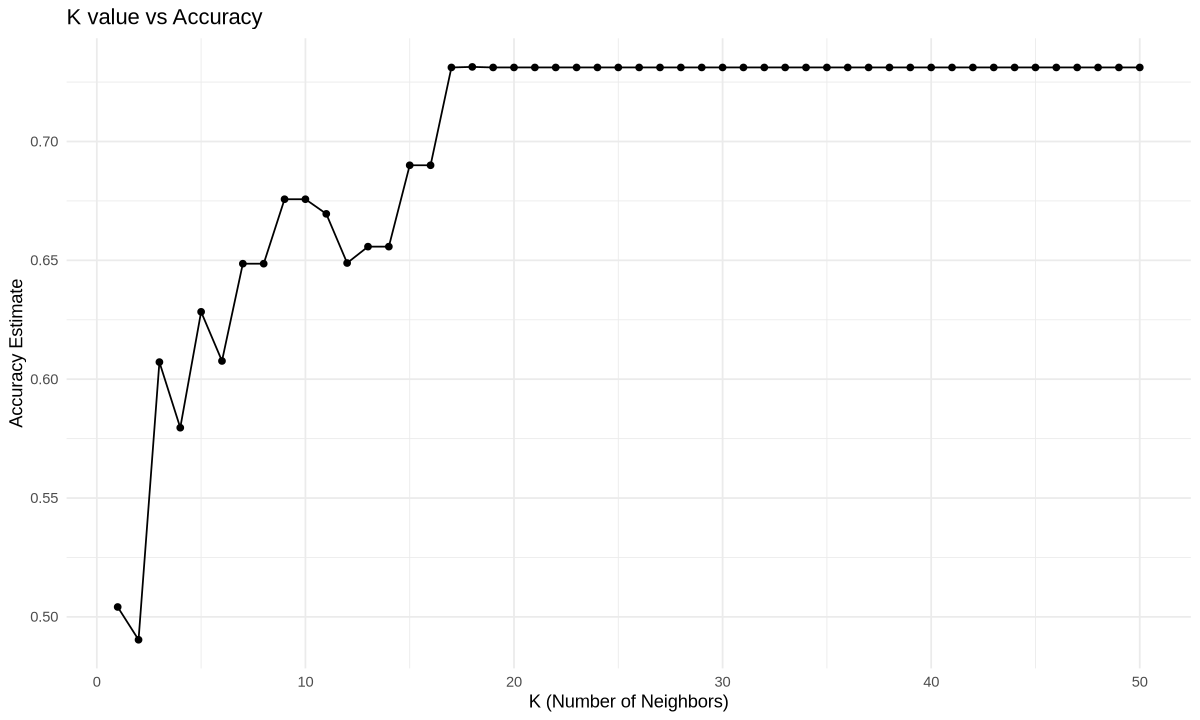

In [23]:
accuracies <- knn_results |>
  collect_metrics() |>
  filter(.metric == "accuracy")
options(repr.plot.width = 10, repr.plot.height = 6)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    title = "K value vs Accuracy",
    x = "K (Number of Neighbors)",
    y = "Accuracy Estimate"
  ) +
    theme_minimal()

accuracy_vs_k

**Figure 3: K-Value vs. Accuracy Estimate**:This plot illustrates how the cross-validated accuracy of the KNN model changes as the number of neighbors (K) increases. When K is small, accuracy varies considerably, indicating model instability and potential overfitting. As K approaches 30, accuracy stabilizes at approximately 73.5%, suggesting that larger values of K produce more consistent and reliable performance. 

### Choose the best k value
After examining the graph, we selected the k value that had the highest average accuracy.

In [24]:
best_k <- accuracies |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
best_k

[1] 18

### Train the Final Model with the Best k
Using the optimal value of k identified during cross-validation, we built a new KNN model and trained it on the entire training dataset. In this step, no data was held out for validation, as we aimed to allow the model to learn from all available training observations. This final model was then prepared for evaluation on the previously unseen test set, providing an unbiased estimate of its real-world performance.

In [25]:
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

final_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_knn_spec)

final_fit <- final_workflow |>
  fit(data = player_train)

### Make Predictions and Evaluate the Final Model
Finally, we used the trained KNN model to predict newsletter subscription status on the test dataset. To assess the model’s performance, we calculated several evaluation metrics, including accuracy, precision, and recall.

In [26]:
test_predictions <- predict(final_fit, player_test) |>
  bind_cols(player_test)

# Accuracy
test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Precision
test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

# Recall
test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# matrix
confusion <- test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
confusion


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7291667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9722222


          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

| Metric   | Estimation | 
|---------------|---------|
|Accuracy | 0.71|
 |Precision| 0.72  | 
 |Recall         |0.97  | 
 
 <p style="text-align: center;"><strong>Table 3:</strong> Evaluation Metrics for Final KNN Model on Test Set (k = 18)</p>
 

|               | Truth: FALSE | Truth: TRUE |
|---------------|--------------|-------------|
| Predicted: FALSE |      0       |      1      |
| Predicted: TRUE  |     13       |     35      |

<p style="text-align: center;"><strong>Table 4:</strong> Confusion Matrix for Final KNN Model Predictions on the Test Set</p>



# Discussion:

#### Summary of Findings

Using Age and played_hours, we can roughly predict whether a player will subscribe to the newsletter. On the test set, the model reached about 71.4% accuracy, 72.9% precision, and 97.2% recall. The model is very good at identifying subscribed players (high recall), but it sometimes incorrectly predicts that non-subscribers are subscribed (lower precision).

#### Is This What I Expected?
This result is partly what I expected.
Players who have played more hours might be more engaged with the game, which makes them more likely to subscribe.
However, I thought age would have a bigger effect. Based on the plot, age is more spread out and doesn’t seem to show a clear pattern.

#### Potential Impact
This model could help the company figure out which players are more likely to subscribe, so they can focus their marketing efforts on those players. That way, they don’t have to send the same message to everyone, which might be annoying for people who aren’t interested.
If we add more features like game level, how often someone logs in, or how long they usually play, the model could probably make even better predictions.
In the long run, something like this could also help the company personalize the player experience or come up with smarter ways to keep players engaged.

#### Future Questions
What other variables could help improve the prediction? Maybe preferred game types or how often players interact with the platform.
Could we build an automated system that recommends newsletter subscriptions in real time?
Are there differences between age groups? For example, do younger and older players subscribe at different rates?

# References